In [2]:
import requests
import pandas as pd

# Credentials
consumer_key = "aBqUYvVqFhPhst8FXy4ZHa9GU"
consumer_secret = "TM9wwYNKca1j85wBh21m03ZyEKVv4aNHHv3pULnPsYXXWp4cRk"
access_token = "782220683564748800-B5pGV21xe5mfdAjeaR9eSUTF5dWDNz8"
access_token_secret = "kr2E9bCOHwfjElkGHB1UdAHqtOkIUaUWfC1GQhwZ2N5cR"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAJjYewEAAAAAm6PKdlVVO6XY%2FchLn%2BIdpQ0YCig%3DjwF0CFBFwNkqbmIa4bbrcMhZhlAO1bcLRDFBIW4yYDv4ycvZj8"
headers = {"Authorization": "Bearer {}".format(bearer_token)}

## Fetch tweets related to the various sectors: health, transportation, education, and food

In [3]:
sector_queries = {
    "health": [
        "healthcare ghana", "medical care ghana", "health care ghana",
        "quality health ghana", "poor health ghana"
    ],
    "transportation": [
        "road network ghana",
        "transportation ghana",
        "fuel price ghana",
    ],
    "education": [
        "education in ghana",
        "teaching learning in ghana",
        "ghana education system",
    ],
    "food": [
        "food price ghana", "food cost ghana", "meals per day system",
        "meal a day system", "diet pattern", "diet change"
    ],
}

In [5]:
# Get tweets
for sector, sector_phrases in sector_queries.items():
    # Pandas dataframe to store the data
    tweet_data_frame = pd.DataFrame(columns=[
        'tweet_id', 'tweet_text', 'sector', 'sentiment_score', 'neg_pos'
    ])
    records = []
    for phrase in sector_phrases:
        print(f"Getting tweets for '{phrase}'")

        query = "+".join(phrase.split())
        url = f"https://api.twitter.com/2/tweets/search/recent?max_results=100&expansions=geo.place_id&query={query} -is:retweet"
        res = requests.get(url, headers=headers)

        # Check if the response is valid
        if res.status_code != 200 or res.json().get("data") is None:
            print("Could not get tweets for phrase: {}".format(phrase))
            continue

        for tweet in res.json().get("data"):
            tweet_object = {
                "tweet_id": tweet.get("id"),
                "tweet_text": tweet.get("text"),
                "sector": sector
            }
            records.append(tweet_object)

        # Fetch next the pages of this query
        while res and res.json().get("meta") and res.json().get("meta").get(
                "next_token"):
            print("Fetching next page for phrase '{}'".format(phrase))

            next_token = res.json().get("meta").get("next_token")
            url += "&next_token={}".format(next_token)
            res = requests.get(url, headers=headers)

            # Check if the response is valid
            if res.status_code != 200 or res.json().get("data") is None:
                print("No more tweets for '{}'".format(phrase))
                continue

            for tweet in res.json()["data"]:
                tweet_object = {
                    "tweet_id": tweet.get("id"),
                    "tweet_text": tweet.get("text"),
                    "sector": sector
                }
                records.append(tweet_object)

    tweet_data_frame = pd.concat(
        [tweet_data_frame,
         pd.DataFrame.from_records(records)])

    # Save the sector data to a csv file
    tweet_data_frame.to_csv("data/" + sector + '.csv', index=False)


Getting tweets for 'healthcare ghana'
Getting tweets for 'medical care ghana'
Getting tweets for 'health care ghana'
Getting tweets for 'quality health ghana'
Getting tweets for 'poor health ghana'
Getting tweets for 'road network ghana'
Getting tweets for 'transportation ghana'
Getting tweets for 'fuel price ghana'
Getting tweets for 'education in ghana'
Fetching next page for phrase 'education in ghana'
Fetching next page for phrase 'education in ghana'
No more tweets for 'education in ghana'
Getting tweets for 'teaching learning in ghana'
Getting tweets for 'ghana education system'
Getting tweets for 'food price ghana'
Getting tweets for 'food cost ghana'
Getting tweets for 'meals per day system'
Getting tweets for 'meal a day system'
Getting tweets for 'diet pattern'
Getting tweets for 'diet change'
Fetching next page for phrase 'diet change'
Fetching next page for phrase 'diet change'
No more tweets for 'diet change'


## Merge all the sectors

In [6]:
df_exists = False
dfs = []
for file_name in sector_queries.keys():
    try:
        dfs += [pd.read_csv("data/" + file_name + ".csv")]
        df_exists = True
    except FileNotFoundError:
        pass
        print("data/" + file_name + ".csv" + " not found.")
if df_exists:
    df = pd.concat(dfs)
    df.to_csv("data/all_sectors.csv", index=False)
else:
    print("No data to save.")

In [118]:
df.describe()

,tweet_id,sentiment_score,neg_pos,Unnamed: 0
count,5.169000e+03,0.0,0.0,1845.000000
mean,1.573094e+18,NaN,NaN,112.027100
std,6.537733e+14,NaN,NaN,78.548791
min,1.571454e+18,NaN,NaN,0.000000
25%,1.572563e+18,NaN,NaN,46.000000
50%,1.573208e+18,NaN,NaN,92.000000
75%,1.573719e+18,NaN,NaN,178.000000
max,1.574010e+18,NaN,NaN,270.000000


# Sentiment analysis

In [67]:
tweet_data_frame = pd.read_csv("data/all_sectors.csv")
tweet_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         701 non-null    int64  
 1   tweet_text       701 non-null    object 
 2   sector           701 non-null    object 
 3   sentiment_score  0 non-null      float64
 4   neg_pos          0 non-null      float64
dtypes: float64(2), int64(1), object(2)
memory usage: 27.5+ KB


## Drop mentions in tweett

In [68]:
# Count missing values
tweet_data_frame.isna().sum()

tweet_id             0
tweet_text           0
sector               0
sentiment_score    701
neg_pos            701
dtype: int64

In [69]:
def remove_mentions(text):
    sentence = []
    for word in text.split():
        if ("@" in word[0] or "#" in word[0] or "https" in word):
            continue
        sentence.append(word)
    return " ".join(sentence)

tweet_data_frame["tweet_text"] = tweet_data_frame["tweet_text"].apply(
    remove_mentions)

In [70]:
tweet_data_frame["tweet_text"]

0      Are you satisfied with how government of Ghana...
1      Ghana have insurance card that you can use to ...
2      How these professionals are underrated in Ghan...
3      How these professionals are underrated in Ghan...
4      Goal 1: End poverty : Ghanaian are poorer than...
                             ...                        
696    Netflix: Santa Clarita Diet - NETFLIX � - Sign...
697    I’m changing my diet and I’m excited to see wh...
698    ...and academic silos, as I've found while sea...
699    Happy birthday! I know what you mean about see...
700    Practical Expectations and a Healthy Diet. It’...
Name: tweet_text, Length: 701, dtype: object

## Detect sentiments

In [71]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hrd/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [75]:
sentiments = []
sentiments_score = []
full_name = {"neu": "neutral", "pos": "positive", "neg": "negative"}
for row in range(len(tweet_data_frame)):
    sentence = tweet_data_frame["tweet_text"][row]
    sentiment = None
    sid = SentimentIntensityAnalyzer()
    predictions = sid.polarity_scores(sentence)
    predictions = sorted([(k, v)
                          for k, v in predictions.items() if k != "compound"],
                         key=lambda a: -a[1])
    sentiment = full_name[predictions[0][0]]

    sentiments.append((sentence,sentiment))
    sentiments_score.append(sentiment)

# tweet_data_frame["sentiment_score"] = sentiments

In [90]:
from collections import Counter
sentiment_counter = Counter(sentiments_score)

In [91]:
sentiments

[('Are you satisfied with how government of Ghana is handling healthcare?',
  'neutral'),
 ('Ghana have insurance card that you can use to access basic healthcare in hospitals,it is renewable every year.',
  'neutral'),
 ("How these professionals are underrated in Ghana, I don't understand. It's one thing is working on, we will give you so much respect, you are at the heart of healthcare in Africa, and that is being overlooked and it is not okay. Happy World Pharmacists Day ♥",
  'neutral'),
 ("How these professionals are underrated in Ghana, I don't understand. It's one thing is working on, we will give you so much respect, you are at the heart of healthcare in Africa, and that is being overlooked and it is not okay. Happy World Pharmacists Day ♥",
  'neutral'),
 ('Goal 1: End poverty : Ghanaian are poorer than we’ve been 4 - 6 years ago. Goal 2: End hunger. More Ghanaian are hungry due to high cost food in Ghana. Goal 3 : Good healthcare :More health professionals have fled the count

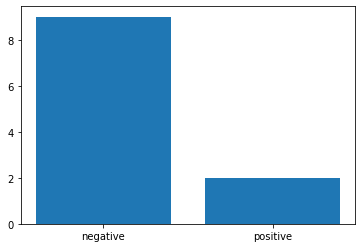

In [92]:
import matplotlib.pyplot as plt
sentiment_counter.pop("neutral") # remove neutral sentiment
plt.bar(*zip(*sentiment_counter.items()))
plt.show()


# General Sentiment

In [95]:
for sentiment, count in sentiment_counter.items():
    if count == max(sentiment_counter.values()):
        print(f"The most common sentiment is {sentiment} with {count} tweets")

The most common sentiment is negative with 9 tweets
